In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

In [2]:
ticker = "AAPL"
start_date = "2014-01-01"
end_date = "2024-01-18"

# Download the historical data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
#print(data.shape)
print(data.iloc[-10:, :])

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-01-03  184.220001  185.880005  183.429993  184.250000  184.250000   
2024-01-04  182.149994  183.089996  180.880005  181.910004  181.910004   
2024-01-05  181.990005  182.759995  180.169998  181.179993  181.179993   
2024-01-08  182.089996  185.600006  181.500000  185.559998  185.559998   
2024-01-09  183.919998  185.149994  182.729996  185.139999  185.139999   
2024-01-10  184.350006  186.399994  183.919998  186.190002  186.190002   
2024-01-11  186.539993  187.050003  183.619995  185.589996  185.589996   
2024-01-12  186.059998  186.740005  185.190002  185.919998  185.919998   
2024-01-16  182.160004  184.259995  180.929993  183.630005  183.630005   
2024-01-17  181.270004  182.929993  180.300003  182.679993  182.679993   

              Volume  
Date                  
2024-01-03  58414500  
2024-01-04  71983600  
2024-01-05  6230330

In [3]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
import models.basic
import utils.MA

In [5]:
history_size = 200
forecast_size = 2
val_percent = 0.05 #percent of data reserved as validation data
batch_size = 128

model = models.basic.Basic2(history_size, forecast_size)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [6]:
tensor = torch.tensor(data.iloc[:, 0:4].values).to(torch.float32)
close = tensor[:, 3]

MA100 = utils.MA.MA(close, 100)[:, None] # N - days + 1
valid_days = MA100.shape[0]
MA60 = utils.MA.MA(close, 60)[-valid_days:, None]
MA20 = utils.MA.MA(close, 20)[-valid_days:, None]
MA5 = utils.MA.MA(close, 5)[-valid_days:, None]
tensor = tensor[-valid_days:, :]

tensor = torch.cat((tensor, MA5, MA20, MA60, MA100), dim=1)
#print(tensor.shape)

tensor = tensor.unfold(0, history_size + forecast_size, 1) #(all_data, 8, hist+fore)
print(tensor.shape)
shape = tensor.shape

size = tensor.shape[0]
train_size = int(size * (1 - val_percent))
shuffle_idx1 = torch.randperm(train_size)
shuffle_idx2 = torch.arange(size - train_size) + train_size
shuffle_idx = torch.cat((shuffle_idx1, shuffle_idx2))
#shuffle = (tensor[shuffle_idx]).flatten(start_dim=-2) #shuffle data (all_data, hist+fore * 8)
shuffle = tensor[shuffle_idx] #(N, 8, hist + fore)

X_train = shuffle[:train_size, :, :history_size].flatten(start_dim=-2)
y_train = shuffle[:train_size, 3, history_size:]

X_val = shuffle[train_size:, :, :history_size].flatten(start_dim=-2)
y_val = shuffle[train_size:, 3, history_size:]
'''
X_train = shuffle[:train_size, :history_size*8]
y_train = shuffle[:train_size, history_size*8:].reshape((train_size, forecast_size, 8))[:, :, :4]
X_val = shuffle[train_size:, :history_size*8]
y_val = shuffle[train_size:, history_size*8:].reshape((size - train_size, forecast_size, 8))[:, :, :4]
'''

data_train = TensorDataset(X_train, y_train)
train_data_loader = DataLoader(data_train, batch_size=batch_size)#, shuffle=True) #shuffle is intended before splitting train and val

def MAPE_loss_fn(t, p): #truth and prediction
    return torch.mean(100 * torch.abs(t-p)/torch.clamp(torch.abs(t), min=1e-8))
loss_fn = MAPE_loss_fn

torch.Size([2227, 8, 202])


In [7]:
def train(model, optimizer, loss_fn, train_data_loader, val_data, epoch = 1):
    iteration_per_epoch = len(train_data_loader)
    total_iteration = iteration_per_epoch * epoch
    train_loss_hist = []
    val_loss_hist = []
    model.train()
    X_val, y_val = val_data
    for _e in range(epoch):
        for t, (X, y) in enumerate(train_data_loader):
            model.train()
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            train_loss_hist.append(loss.item())
            loss.backward()
            optimizer.step()
            iteration = _e*iteration_per_epoch + t
            with torch.no_grad():
                val_pred = model(X_val)
                val_loss = loss_fn(val_pred, y_val)
                val_loss_hist.append(val_loss.item())
            print(f'training on iteration:{iteration}    \t/{total_iteration}, val loss:{val_loss.item()}')
    model_weight = model.state_dict()
    return model_weight, train_loss_hist, val_loss_hist

def show_loss_stats(train_loss, val_loss):
    x = range(len(train_loss))
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, val_loss, label='val_loss')
    plt.legend()
    plt.ylim(0, 100)
    plt.show()

training on iteration:0    	/3400, val loss:58.693241119384766
training on iteration:1    	/3400, val loss:34.58342361450195
training on iteration:2    	/3400, val loss:51.93033981323242
training on iteration:3    	/3400, val loss:60.07009506225586
training on iteration:4    	/3400, val loss:64.44955444335938
training on iteration:5    	/3400, val loss:67.01636505126953
training on iteration:6    	/3400, val loss:68.46025085449219
training on iteration:7    	/3400, val loss:69.03370666503906
training on iteration:8    	/3400, val loss:68.87689971923828
training on iteration:9    	/3400, val loss:67.93932342529297
training on iteration:10    	/3400, val loss:65.99433135986328
training on iteration:11    	/3400, val loss:62.333412170410156
training on iteration:12    	/3400, val loss:55.08646774291992
training on iteration:13    	/3400, val loss:49.457279205322266
training on iteration:14    	/3400, val loss:63.869972229003906
training on iteration:15    	/3400, val loss:45.8021965026855

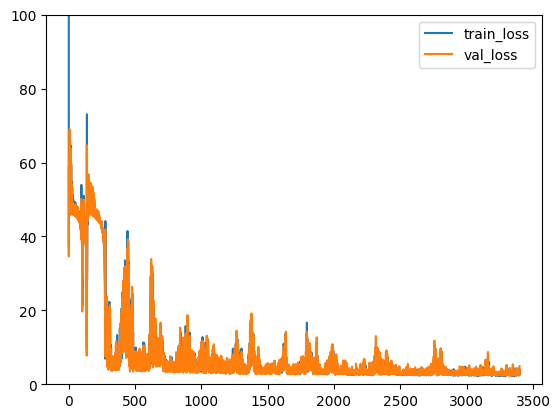

In [8]:
model_weight, train_loss_hist, val_loss_hist = train(model, optimizer, loss_fn, train_data_loader, [X_val, y_val], epoch=200)
modelSaveDirectory = './state_dict/basic'
torch.save(model_weight, f"{modelSaveDirectory}.pth")
show_loss_stats(train_loss_hist, val_loss_hist)

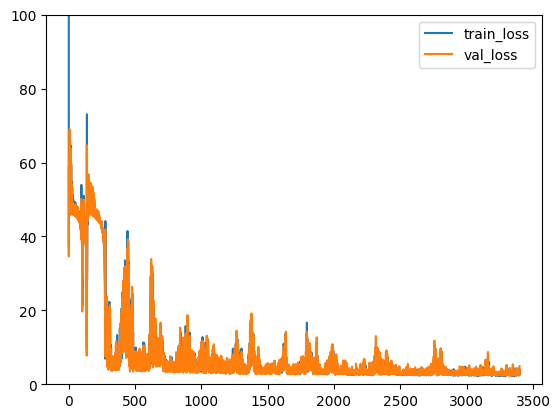

In [9]:
show_loss_stats(train_loss_hist, val_loss_hist)